Source:

huggingface: https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews

Tutorial:https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/sharif/FineTuning/ipython(guide)')

In [3]:
!pip install transformers==2.8

     |████████████████████████████████| 573kB 8.4MB/s 
     |████████████████████████████████| 133kB 17.6MB/s 
     |████████████████████████████████| 3.7MB 18.5MB/s 
     |████████████████████████████████| 890kB 59.4MB/s 
     |████████████████████████████████| 1.2MB 53.5MB/s 
     |████████████████████████████████| 7.2MB 45.5MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=d57bb8e3cc416cf3acaa7883b1b9bb7b67868353250fa98dffcabd0f49dd810f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.54 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [4]:
!pip3 install sentencepiece

In [ ]:
!git clone https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews
GIT_LFS_SKIP_SMUDGE=1

fatal: destination path 'bert-fa-base-uncased-clf-persiannews' already exists and is not an empty directory.


In [5]:
import torch
import numpy
import pandas
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,TFAutoModel,AutoModel
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import classification_report

In [6]:
# specify GPU
device = torch.device("cuda")

## Data

In [7]:
limit_number = 750
data = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv',index_col=0)
data = data.dropna().reset_index(drop=True)
X = data["body"].values.tolist()
y = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv')
labels = []
tag=[]
for item in y['tag']:
  labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
  tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
labels = list(set(labels))
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(tag)

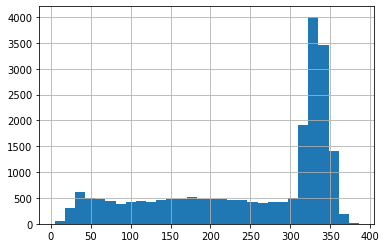

In [ ]:
seq_len = [len(i.split()) for i in X]
pandas.Series(seq_len).hist(bins = 30)

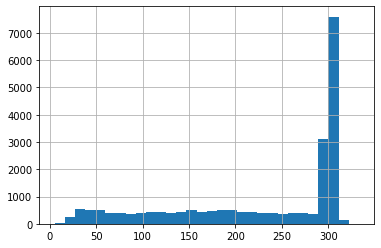

In [ ]:
seq_len = [len([j for j in i.split() if len(j)>2]) for i in X]
pandas.Series(seq_len).hist(bins = 30)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('train: ', len(X_train) , '\ntest: ', len(X_test) , '\nval: ', len(X_val) ,"\ny_tain:",len(y_train) )

train:  12896 
test:  4299 
val:  4299 
y_tain: 12896


In [9]:
##we would load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

In [ ]:
#example
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenized=tokenizer.tokenize(X_train[0])
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(input_ids)


['نمی', 'دونم', 'واقعی', '##ه', 'خونده', 'می', 'خوا', '##ی', 'مطمين', 'بشی', 'تصمیم', '##ت', 'ببین', 'گرفتی', '##ش', 'جهان', 'طوری', 'باهات', 'می', 'کنه', 'داره', 'برنامه', 'می', 'ره', 'سنگ', '##ای', 'ریز', 'درشت', 'پات', 'می', 'افت', '##ه', 'قدرتی', 'می', 'خواد', 'جلوت', 'بایسته', 'می', 'تونی', 'امیدوار', 'قدما', '##ی', 'اولو', 'برداشتی', 'شبیه', 'قصه', 'ی', 'اکت', 'نیتی', '##و', 'روزی', 'بسم', 'الله', 'درگیر', 'اتفاقا', '##یی', 'قاعدتا', 'هفته', 'می', 'افتادن', 'صفحه', 'کلید', 'تاپ', 'مقدمه', 'کار', 'افتاد', 'روزای', 'اسفند', 'بتونه', 'درستش', 'کنه', 'بشه', 'صفحه', 'کلید', 'خرید', 'اندازه', 'ی', 'کشف', 'واکسن', 'کرونا', 'می', 'رسید', 'کیبورد', 'قدیمی', 'امانت', 'اونم', 'دکمه', 'ی', 'اسپیس', 'مجبور', 'تیکه', 'پاک', 'توش', 'کار', 'بذارم', 'اونم', 'کار', 'افتاد', 'بعدم', 'تعمیرکار', 'اومدم', 'دیدم', 'کیبورد', '##و', 'تعمیر', 'ویندوز', '##مم', 'پریده', 'الله', 'اکبر', 'اقبال', 'بلند', 'خونسردی', '##مو', 'حفظ', 'بگم', 'خیال', 'دست', 'برمی', 'تاپ', 'حالش', 'نشد', 'مهمی', 'اطلاعاتم', 'دست',

In [ ]:
# encode text
sent_id = tokenizer.batch_encode_plus(X_train[:10], padding=True, return_token_type_ids=False)

In [ ]:
sent_id

{'input_ids': [[2, 5071, 4790, 32701, 3911, 19910, 74701, 3329, 52810, 2030, 4613, 57968, 7341, 4957, 3916, 3911, 4613, 9607, 39230, 4378, 28724, 36539, 5929, 15619, 20936, 41215, 2002, 5102, 57637, 6012, 74701, 5565, 2867, 5929, 26040, 6501, 4484, 64198, 5438, 13334, 23344, 58164, 6012, 6820, 58164, 4766, 6667, 33103, 35204, 6921, 37745, 23460, 4366, 5929, 2959, 45309, 8146, 4856, 4613, 2938, 5782, 4394, 2959, 45098, 60379, 2061, 45309, 8146, 29511, 5929, 52446, 11231, 2867, 6921, 8094, 52810, 64831, 35138, 33103, 62321, 4366, 5929, 2959, 27409, 45309, 8146, 23460, 4613, 35667, 33103, 62321, 6921, 37745, 4366, 5929, 33336, 2959, 27409, 45309, 8146, 52810, 64831, 35138, 4484, 18009, 92228, 74701, 37458, 48687, 52446, 22157, 45498, 29420, 4090, 23709, 2050, 30750, 7796, 6945, 11999, 32701, 3528, 10672, 35428, 17389, 5655, 3030, 5071, 3329, 52810, 2030, 4613, 44594, 18230, 4790, 52248, 7120, 28678, 10741, 3531, 3916, 45309, 62071, 88012, 5929, 74701, 3462, 5289, 7222, 5071, 96817, 88012,

In [10]:
sentence_maxlen=128

In [11]:
##Tokenize training and validation sentences:
train_encodings = tokenizer.batch_encode_plus(X_train,
    max_length = sentence_maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)

val_encodings = tokenizer.batch_encode_plus(X_val,
    max_length = sentence_maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)

test_encodings=tokenizer.batch_encode_plus(X_test,
    max_length = sentence_maxlen,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)

In [ ]:
train_encodings[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [12]:
import torch
import torch.nn as nn

# for train set
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.tensor(y_train)

# for validation set
val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.tensor(y_val)

# for test set
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.tensor(y_test)

In [ ]:
train_y[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0])

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# example


text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

seq = torch.tensor(sent_id['input_ids'])
mask = torch.tensor(sent_id['attention_mask'])
train_y = torch.tensor([0,1])

transformer_model = AutoModel.from_pretrained("bert-base-multilingual-cased")
cls_hs=transformer_model(seq,mask)
print(cls_hs)
print(cls_hs[0])
print(cls_hs[1])
print(cls_hs[1].shape)

{'input_ids': [[101, 10531, 10124, 169, 10347, 10976, 13192, 69635, 34108, 102], [101, 11951, 11337, 13435, 118, 91695, 169, 10347, 10976, 13192, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


ValueError: ignored

## Model

In [14]:
transformer_model = AutoModel.from_pretrained("bert-base-multilingual-cased")

In [15]:
# freeze all the parameters
for param in transformer_model.parameters():
    param.requires_grad = False

In [ ]:
len(labels)

78

In [26]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,78)


      #sigmoid activation function
      self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs[1])

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply sigmoid activation
      x = self.sigmoid(x)

      return x

In [27]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [28]:
# optimizer from hugging face transformers
from transformers import AdamW

# optimizer = AdamW(model.parameters(), lr = 1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [29]:
loss_func =nn.MultiLabelSoftMarginLoss()

In [30]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    
    loss = loss_func(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [31]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = loss_func(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [32]:
# number of training epochs
epochs = 10

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_multi.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    403.
  Batch   100  of    403.
  Batch   150  of    403.
  Batch   200  of    403.
  Batch   250  of    403.
  Batch   300  of    403.
  Batch   350  of    403.
  Batch   400  of    403.

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.962
Validation Loss: 0.961

 Epoch 2 / 10
  Batch    50  of    403.
  Batch   100  of    403.
  Batch   150  of    403.
  Batch   200  of    403.
  Batch   250  of    403.
  Batch   300  of    403.
  Batch   350  of    403.
  Batch   400  of    403.

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.961
Validation Loss: 0.960

 Epoch 3 / 10
  Batch    50  of    403.
  Batch   100  of    403.
  Batch   150  of    403.
  Batch   200  of    403.
  Batch   250  of    403.
  Batch   300  of    403.
  Batch   350  of    403.
  Batch   400  of    403.

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.960
Validation Loss: 0

Loading saved model:

In [ ]:
# torch.cuda.empty_cache()
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

After loading model:

In [33]:
y_pred=[]
y_true=[]
for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      # print(preds)
      # print(preds.cpu().numpy())
      preds = preds.cpu().numpy()
      # model's performance
    # preds = numpy.argmax(preds, axis = 1)
    
    measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    for l in preds:
      temp=[]
      for value in l:
        if value >= measure:
          temp.append(1)
        else:
          temp.append(0)
      y_pred.append(temp)
    y_true.extend(labels.cpu().numpy())
    # print(labels.cpu().numpy()[0], preds[0])
print(classification_report(y_true, y_pred))

  Batch    50  of    135.
  Batch   100  of    135.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       118
           1       0.00      0.00      0.00       167
           2       0.00      0.00      0.00       162
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        80
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00       160
           7       0.00      0.00      0.00        51
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00       108
          10       0.00      0.00      0.00       146
          11       0.00      0.00      0.00        84
          12       0.00      0.00      0.00       154
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        18
          15       0.00      0.00      0.00       147
          16       0.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
